# TensorFlow Tutorial #11
# Adversarial Examples

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

이전 튜토리얼에서, 우리는 이미지를 분류하기 위한 심층 신경망의 여러 종류를 사용했다. 이 튜토리얼에서 우리는 신경망이 어떤 이미지든 우리가 선택한 클래스로 잘못 분류하게 만드는 Adversarial Examples라 불리는 것을 찾는 것에 대한 간단한 방법을 볼 것이다. 입력 이미지에 '특수한' 노이즈를 약간 더하는 것만으로 간단히 된다. 이 변화는 인간은 알아챌 수 없지만 신경망을 바보로 만든다.

이건 이전 튜토리얼로부터 만들어진다. 일반적인 신경망에 익숙해야만 하고 인셉션 모델의 지식이 도움 될 것이다.

## Flowchart

우리는 튜토리얼 7로부터 인셉션 모델을 사용할 것이고, 인셉션 모델이 입력 이미지를 잘못 분류하도록 하는 적대적 예제를 찾기 위해 텐서플로 그래프를 바꾼다.

아래의 플로우 차트에서, Willy Wonka의 이미지는 약간의 노이즈가 더해지고 그 결과는 인셉션 모델에 입력으로 사용된다. 목표는 인셉션이 이미지를 우리가 원하는 타겟 클래스(클래스 숫자 300, `bookcase`)로 잘못 분류하게 만드는 노이즈를 찾아내는 것이다.

우리는 또한 새로운 손실이나 비용함수를 그래프에 더하여 인셉션 모델이 노이즈 이미지를 얼마나 잘 분류하는지 성능을 측정하기 위해 크로스 엔트로피를 계산한다. 

왜냐하면 인셉션 모델은 많은 수학 연산이 결합되어 구성되었다. 텐서플로는 미분의 체인룰을 사용하여 손실 함수의 그라디언트를 쉽게 찾을 수 있게 한다

우리는 입력 이미지에 대해 손실 함수의 그라디언트를 사용하고, 적대적 노이즈를 찾게 우리를 이끈다. 입력 이미지의 실제 분류보다 'bookcase'에 대해 분류 점수를 증가시키는 노이즈를 찾는다.

특히 기울기 강하를 사용해 최적화를 수행하고 아래에서 구현된다.

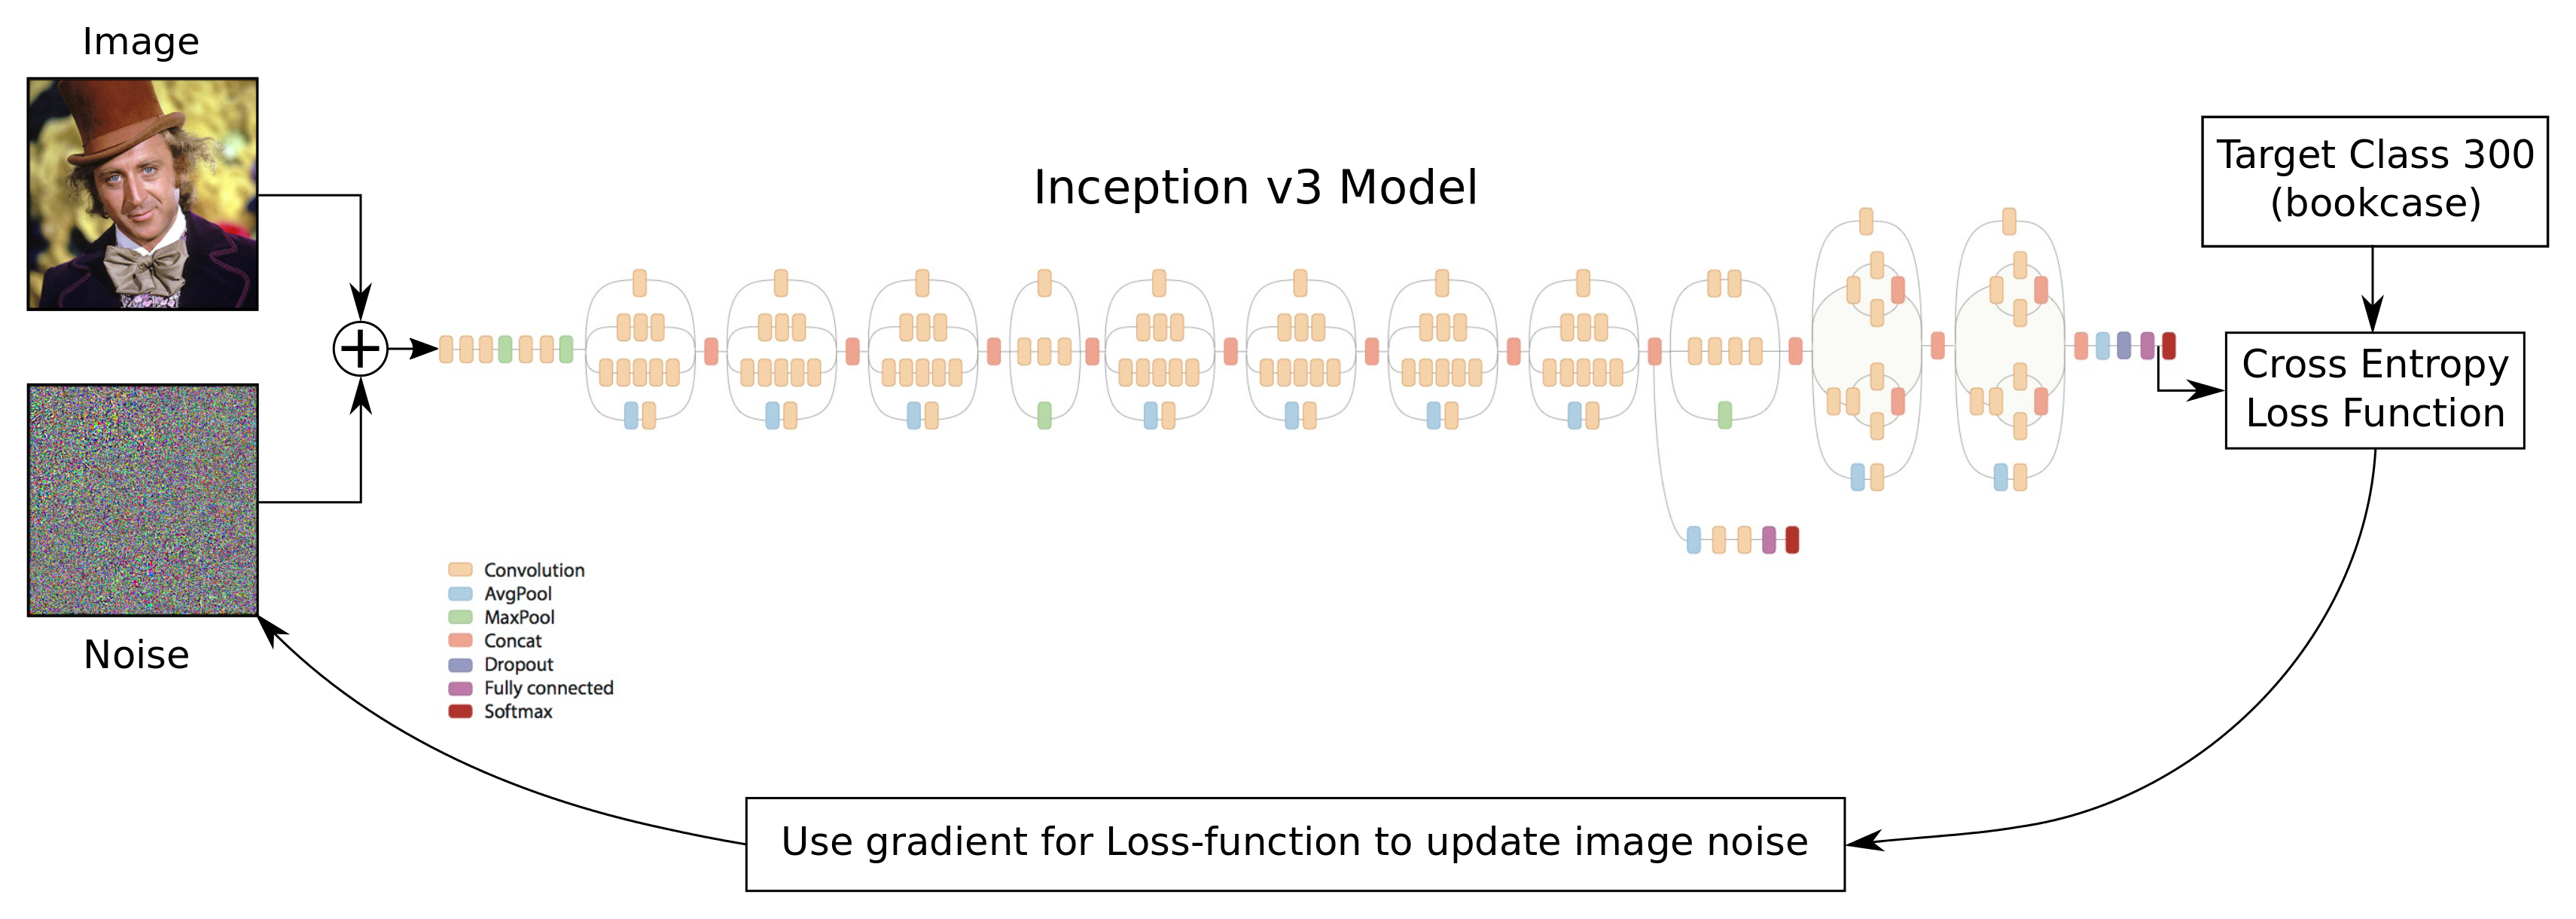

In [1]:
from IPython.display import Image, display
Image('images/11_adversarial_examples_flowchart.png')

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# Functions and classes for loading and using the Inception model.
import inception

파이썬 3.5.2 (아나콘다)와 텐서플로 1.0.1 버젼으로 함

In [3]:
tf.__version__

'1.0.1'

## Inception Model

### Download the Inception model from the internet

인터넷으로부터 인셉션 모델을 다운받는다. 데이터파일을 저장하려는 기본 디렉토리. 이 디렉토리는 존재하지 않으면 만들어진다.

In [4]:
# inception.data_dir = 'inception/'

디렉토리에 존재하지 않으면 인셉션 모델에 대한 자료를 받는다. 이것은 85 MB.

In [5]:
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


### Load the Inception Model

인셉션 모델을 불러왔으므로 이미지를 분류하기 위한 준비가 되었다.

deprecation 경고는 이 프로그램이 미래에 실패할 수도 있다는 것을 나타낸다

In [6]:
model = inception.Inception()

### Get Input and Output for the Inception Model

인셉션 모델에 대한 입력 텐서에 대한 참조를 가져오자. 이 텐서는 줄어든 이미지이다. 즉 299 x 299 x 3 의 raw byte이다. 이 줄어든 이미지에 노이즈를 더하고, 그 결과를 그래프에 보낸다.  그러므로 노이즈는 리사이징 알고리즘에 의해 처리되지 않는다.

In [7]:
resized_image = model.resized_image

인셉션 모델에 대한 소프트맥스 분류기의 출력에 대한 참조를 가져오자

In [8]:
y_pred = model.y_pred

인셉션 모델에 대한 소프트맥스 분류기의 정규화되지 않은 출력의 참조를 가져오자. 이것은 자주 'logits' 이라고 불린다. logits은 그래프에 새로운 손실 함수를 더하기 위해 필요하다

In [9]:
y_logits = model.y_logits

### Hack the Inception Model

적대적 예제를 찾기 위해 인셉션 모델 그래프에 새로운 손실함수를 더할 필요가 있다. 입력 이미지에 대해 손실함수의 그라디언트 또한 필요하다.

In [10]:
# 인셉션 모델 그래프를 기본 그래프로써 설정하면 블록 내에 모든 변화는 그래프에 반영된다.
with model.graph.as_default():
    # 타겟 클래스 번호에 대해 placeholder 변수를 받는다.
    # 'bookcase' 클래스에 대한 300으로 설정될 것이다.
    pl_cls_target = tf.placeholder(dtype=tf.int32)

    # 새로운 손실 함수를 더한다. 이것은 크로스 엔트로피다
    # 크로스 엔트로피에 대한 설명은 튜토리얼 1을 보라
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_logits, labels=[pl_cls_target])

    # 줄어든 입력 이미지에 대한 손실함수의 그라디언트를 얻는다.
    gradient = tf.gradients(loss, resized_image)

## TensorFlow Session

그래프를 실행하기 위해 텐서플로 세션이 필요하다

In [11]:
session = tf.Session(graph=model.graph)

## Helper-function for finding Adversary Noise

뒤의 함수는 원하는 타겟 클래스로 분류되도록 하는 주어진 입력 이미지에 더해진 노이즈를 찾는다.

이 함수는 특히 기울기 강하로 최적화를 수행한다. 이 노이즈는 0으로 초기화되고 노이즈 입력 이미지에 대한 손실 함수의 그라디언트를 사용해 반복적으로 업데이트되므로 각 단계에서 노이즈로 인해 원하는 타겟 클래스에 가깝게 분류된다. 이 최적화는 타겟 분류가 원하는 점수(99%)에 도달하거나 최대 반복 수를 수행하면 끝난다

In [12]:
def find_adversary_noise(image_path, cls_target, noise_limit=3.0,
                         required_score=0.99, max_iterations=100):
    """
    타겟 클래스로 분류되게 만드는 입력 이미지에 더해지는 노이즈를 찾는다
    
    image_path: 입력 이미지에 대한 파일 경로 (*.jpg 여야만 한다)
    cls_target:  타겟 클래스 숫자 (1-1000 사이 정수)
    noise_limit:  노이즈에서 픽셀값의 한계
    required_score: 타겟 클래스 점수가 이것에 도달할 때 멈춘다.
    max_iterations: 수행되는 최대 최적화 반복 수
    """

    # 이미지를 갖는 feed_dict을 만든다
    feed_dict = model._create_feed_dict(image_path=image_path)

    # 텐서플로로 리사이즈된 이미지와 예측 클래스 점수를 계산한다
    pred, image = session.run([y_pred, resized_image],
                              feed_dict=feed_dict)

    # 1차원 배열로 바꾼다
    pred = np.squeeze(pred)

    # 예측된 클래스 숫자
    cls_source = np.argmax(pred)

    # 예측 클래스에 대한 점수 (aka. 확률 or 확신)
    score_source_org = pred.max()

    # 소스와 타겟 클래스에 대한 이름
    name_source = model.name_lookup.cls_to_name(cls_source,
                                                only_first_name=True)
    name_target = model.name_lookup.cls_to_name(cls_target,
                                                only_first_name=True)

    # 노이즈는 0으로 초기화
    noise = 0

    # 입력 이미지를 잘못 분류하게 만드는 노이즈를 찾기 위해 최적화 반복 수를 수행한다
    for i in range(max_iterations):
        print("Iteration:", i)

        # 이 노이즈 낀 이미지는 입력 이미지와 노이즈의 합이다
        noisy_image = image + noise

        # 노이즈 낀 이미지의 픽셀 값이 0과 255 사이임을 보장한다.
        # 만약 픽셀 값이 이 범위 밖이라면 인셉션 모델의 '허락되지 않은' 입력 때문에 잘못 분류할 수도 있다
        noisy_image = np.clip(a=noisy_image, a_min=0.0, a_max=255.0)

        # feed_dict을 만든다. 이것은 리사이즈된 이미지를 가진 그래프에 노이즈 낀 이미지를 보낸다
        # 이것은 또한 우리가 원하는 타겟 클래스 숫자를 보낸다
        feed_dict = {model.tensor_name_resized_image: noisy_image,
                     pl_cls_target: cls_target}

        # 예측 클래스 점수와 그라디언트를 계산한다
        pred, grad = session.run([y_pred, gradient],
                                 feed_dict=feed_dict)

        # 예측 클래스 점수를 1차원으로 바꾼다
        pred = np.squeeze(pred)

        # 원본과 타겟  클래스에 대한 점수
        score_source = pred[cls_source]
        score_target = pred[cls_target]

        # 그라디언트 배열에 대한 차원 늘리기
        grad = np.array(grad).squeeze()

        # 이 그라디언트는 이제 노이즈 낀 이미지가 예측 클래스로부터 바라는 타겟 클래스에 가까워지도록 움직이기 위해
        # 얼마나 변화가 필요한지를 말해준다

        # 절대 그라디언트 값의 최대값을 계산한다
        # 이것은 계단 크기(학습률로 생각)를 계산하기 위해 사용된다.
        grad_absmax = np.abs(grad).max()
        
        # 만약 그라디언트가 너무 작다면 하한을 사용한다
        # 왜냐하면 이것으로 나눌 것이기 때문이다.
        if grad_absmax < 1e-10:
            grad_absmax = 1e-10

        # 이미지 노이즈를 업데이트 하기 위해 계단 크기를 결정한다
        # 이것은 적어도 한 픽셀 색깔이 7만큼 변하는 것을 보장한다.
        # 픽셀 색깔은 255개의 다른 값이 있다는 것을 상기하자
        # 이 계단 크기는 빠르게 수렴하게 하는 것으로 알려졌다.
        step_size = 7 / grad_absmax

        # 점수 출력. 원본 클래스에 대해
        msg = "Source score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}"
        print(msg.format(score_source, cls_source, name_source))

        # 점수 출력. 타겟 클래스에 대해
        msg = "Target score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}"
        print(msg.format(score_target, cls_target, name_target))

        # 그라디언트에 대한 통계량 출력
        msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
        print(msg.format(grad.min(), grad.max(), step_size))

        print()

        # 만약 타겟 클래스에 대한 점수가 충분히 크지 않다면,
        if score_target < required_score:
            # 계단 크기에 의해 스케일링된 그라디언트를 빼줌으로써
            # 이미지 노이즈를 업데이트한다
            noise -= step_size * grad

            # 노이즈가 바라는 범위 안에 있는 것을 보장한다 clip
            # 너무 심한 이미지 왜곡을 피한다.
            noise = np.clip(a=noise,
                            a_min=-noise_limit,
                            a_max=noise_limit)
        else:
            # 충분히 점수가 높으면 최적화를 멈춘다
            break

    return image.squeeze(), noisy_image.squeeze(), noise, \
           name_source, name_target, \
           score_source, score_source_org, score_target

### Helper-function for plotting image and noise

이 함수는 입력이미지를 정규화함으로써 값들이 적절한 노이즈를 출력하기 위해 필요한 0.0과 1.0 사이에 있게 한다

In [13]:
def normalize_image(x):
    # 입력 이미지에 모든 픽셀 들에 대한 최소값과 최대값을 얻는다
    x_min = x.min()
    x_max = x.max()

    # 모든 값을 0.0 과 1.0 사이로 정규화
    x_norm = (x - x_min) / (x_max - x_min)

    return x_norm

이 함수는 원본 이미지, 노이즈 낀 이미지, 노이즈를 표시한다. 이것은 또한 클래스 이름과 점수도 보여준다.

In [14]:
def plot_images(image, noise, noisy_image,
                name_source, name_target,
                score_source, score_source_org, score_target):
    """
    이미지, 노이즈 낀 이미지와 노이즈 표시
    또한 클래스 이름과 점수도 보여준다

    이 노이즈는 전체 범위의 색깔을 사용하도록 증폭된다,
    그렇지 않고 노이즈가 매우 낮으면 보기 어렵다

    image:  원본 입력 이미지.
    noise: 이미지에 더해지는 노이즈 
    noisy_image: 입력 이미지 + 노이즈
    name_source: 원본 클래스의 이름
    name_target: 타겟 클래스의 이름
    score_source: 원본 클래스의 점수
    score_source_org: 원본 클래스의 인셉션 점수 (원래 점수)
    score_target: 타겟 클래스의 점수
    """
    
    # 서브 플랏을 갖는 격자를 만든다
    fig, axes = plt.subplots(1, 3, figsize=(10,10))

    # 간격 조정
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # 픽셀을 부드럽게 하는 내삽법(interpolation)을 사용할 것인가?
    smooth = True
    
    # 내삽법 방식
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    # 원본 이미지 표시
    # 픽셀 값은 255.로 나눠서 범위가 [0.0, 1.0] 으로 정규화 된다.
    ax = axes.flat[0]
    ax.imshow(image / 255.0, interpolation=interpolation)
    msg = "Original Image:\n{0} ({1:.2%})"
    xlabel = msg.format(name_source, score_source_org)
    ax.set_xlabel(xlabel)

    # 노이즈 낀 이미지 표시
    ax = axes.flat[1]
    ax.imshow(noisy_image / 255.0, interpolation=interpolation)
    msg = "Image + Noise:\n{0} ({1:.2%})\n{2} ({3:.2%})"
    xlabel = msg.format(name_source, score_source, name_target, score_target)
    ax.set_xlabel(xlabel)

    # 노이즈 표시
    # 색깔은 증폭된다 그렇지 않다면 보기 어렵다
    ax = axes.flat[2]
    ax.imshow(normalize_image(noise), interpolation=interpolation)
    xlabel = "Amplified Noise"
    ax.set_xlabel(xlabel)

    # 눈금 제거
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

### Helper-function for finding and plotting adversarial example

이 함수는 위의 두개 도움 함수를 결합한다. 첫째는 적대적 노이즈를 찾고 그 노이즈를 갖는 이미지를 표시한다.

In [15]:
def adversary_example(image_path, cls_target,
                      noise_limit, required_score):
    """
    주어진 이미지에 대해 적대적 노이즈를 찾고 표시
    
    image_path: 입력 이미지에 대한 파일 경로 ( *.jpg 여야만 한다)
    cls_target: 타겟 클래스 숫자 (1-1000 사이의 정수)
    noise_limit:  노이즈 픽셀 값들의 한계값
    required_score: 타겟 클래스 점수가 이 점수에 도달 하면 멈춘다
    """

    # 적대적 노이즈를 찾는다
    image, noisy_image, noise, \
    name_source, name_target, \
    score_source, score_source_org, score_target = \
        find_adversary_noise(image_path=image_path,
                             cls_target=cls_target,
                             noise_limit=noise_limit,
                             required_score=required_score)

    # 노이즈와 이미지를 표시
    plot_images(image=image, noise=noise, noisy_image=noisy_image,
                name_source=name_source, name_target=name_target,
                score_source=score_source,
                score_source_org=score_source_org,
                score_target=score_target)

    # 노이즈에 대한 통계값들을 출력
    msg = "Noise min: {0:.3f}, max: {1:.3f}, mean: {2:.3f}, std: {3:.3f}"
    print(msg.format(noise.min(), noise.max(),
                     noise.mean(), noise.std()))

## Results

### Parrot

이 예제는 parrot 입력 이미지를 가지고 인셉션 모델이 이 이미지를 bookcase (클래스 숫자 300) 이라고 잘못 분류하게 만드는 적대적 노이즈를 찾는다

노이즈 한계는 3.0으로 설정 이것은 각 픽셀 색깔이 최대 &plusmn; 3.0 만큼 변하는 것을 허용. 각 픽셀 색은  0 부터 255 사이의 값이므로 &plusmn; 3.0 은 가능한 값의 범위의 약 1.2% 밖에 안된다. 노이즈의 작은 값은 사람 눈으로 구별하기 어려우므로 노이즈 낀 이미지는 정확히 원본 이미지와 같아 보인다.

필요 점수는 0.99로 설정 타겟 분류 점수를 0.99 이상으로 할 때 적대적 노이즈 찾는 최적화를 멈춘다. 그러므로 인셉션 모델은 거의 완벽하게 노이즈 낀 이미지를 바라는 타겟 클래스라고 확신한다.

Iteration: 0
Source score:  97.52%, class-number:  409, class-name: macaw
Target score:   0.00%, class-number:  300, class-name: bookcase
Gradient min: -0.001653, max:  0.001403, stepsize:   4235.64

Iteration: 1
Source score:  86.04%, class-number:  409, class-name: macaw
Target score:   0.02%, class-number:  300, class-name: bookcase
Gradient min: -0.001469, max:  0.002120, stepsize:   3302.27

Iteration: 2
Source score:  67.96%, class-number:  409, class-name: macaw
Target score:   0.06%, class-number:  300, class-name: bookcase
Gradient min: -0.001602, max:  0.001353, stepsize:   4368.61

Iteration: 3
Source score:  21.10%, class-number:  409, class-name: macaw
Target score:   0.16%, class-number:  300, class-name: bookcase
Gradient min: -0.000851, max:  0.000873, stepsize:   8020.36

Iteration: 4
Source score:  28.19%, class-number:  409, class-name: macaw
Target score:   0.32%, class-number:  300, class-name: bookcase
Gradient min: -0.002501, max:  0.002349, stepsize:   2799.22



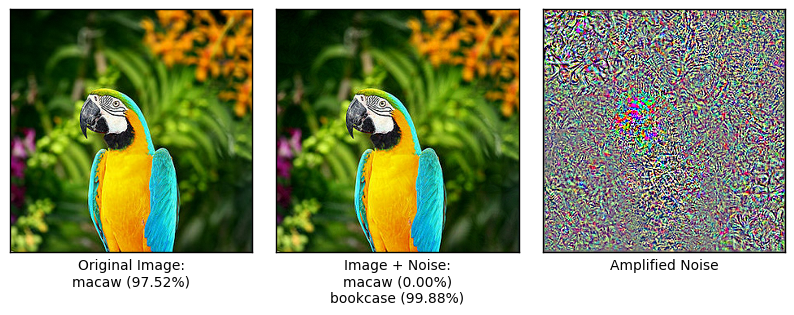

Noise min: -3.000, max: 3.000, mean: 0.003, std: 1.555


In [16]:
image_path = "images/parrot_cropped1.jpg"

adversary_example(image_path=image_path,
                  cls_target=300,
                  noise_limit=3.0,
                  required_score=0.99)

위에 보이는 것처럼, parrot의 원본 이미지는 노이즈 낀 이미지와 정확히 같아 보인다. 사람 눈으로는 두 이미지의 차이를 말할 수 없다. 원본 이미지는 인셉션 모델에 의해 97.38%의 점수로 macaw로 올바르게 분류된다. 하지만 노이즈 낀 이미지는 bookcase에 대해 99.58% 와 macaw에 대해 0.00% 의 분류 점수를 갖는다.

그래서 우리는 인셉션 모델이 parrot 이미지를 bookcase라고 믿도록 바보로 만들었다. 이 잘못 분류는 아주 작은 '특수한' 노이즈를 더해주는 것으로 된다.

위에 나타난 노이즈는 굉장히 증폭되었다. 실제로, 이 노이즈는 입력 이미지의 각 픽셀의 색 강도를 가능한 강도 범위 내에서 최대 1.2%만큼 조정한다. 왜냐하면 노이즈는 매우 작기 때문에, 이 차이는 사람이 구분할 수 없지만 이것은 인셉션 모델이 입력 이미지를 완벽하게 잘못 분류하게 만든다.

### Elon Musk

우리는 Elon Musk 이미지에 대해 적대적 이미지를 찾을 수 있다. 타겟 클래스는 다시 'bookcase' 로 설정한다. 노이즈 한계와 요구 점수도 같게 설정한다

Iteration: 0
Source score:  16.63%, class-number:  837, class-name: sweatshirt
Target score:   0.01%, class-number:  300, class-name: bookcase
Gradient min: -0.003983, max:  0.005454, stepsize:   1283.43

Iteration: 1
Source score:   2.20%, class-number:  837, class-name: sweatshirt
Target score:   0.31%, class-number:  300, class-name: bookcase
Gradient min: -0.006182, max:  0.006406, stepsize:   1092.74

Iteration: 2
Source score:   0.84%, class-number:  837, class-name: sweatshirt
Target score:   8.91%, class-number:  300, class-name: bookcase
Gradient min: -0.005388, max:  0.004422, stepsize:   1299.25

Iteration: 3
Source score:   0.24%, class-number:  837, class-name: sweatshirt
Target score:  72.50%, class-number:  300, class-name: bookcase
Gradient min: -0.000960, max:  0.001146, stepsize:   6110.05

Iteration: 4
Source score:   0.03%, class-number:  837, class-name: sweatshirt
Target score:  62.43%, class-number:  300, class-name: bookcase
Gradient min: -0.002889, max:  0.0016

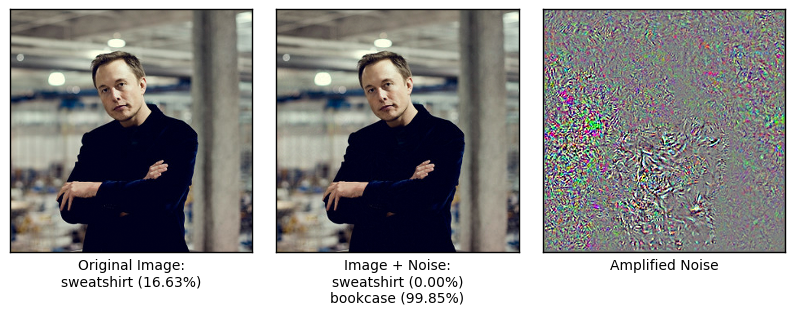

Noise min: -3.000, max: 3.000, mean: -0.001, std: 0.869


In [17]:
image_path = "images/elon_musk.jpg"

adversary_example(image_path=image_path,
                  cls_target=300,
                  noise_limit=3.0,
                  required_score=0.99)

인셉션 모델은 원본 입력 이미지를 분류하는데 혼란스러워서 sweatshirt(점수 16.63%)로 분류했다. 하지만 우리는 인셉션 모델이 완벽하게 노이즈낀 이미지를 bookcase라고 확신하는 적대적 노이즈를 만들 수 있다.

### Willy Wonka (New)

Iteration: 0
Source score:  34.47%, class-number:  535, class-name: sunglasses
Target score:   0.03%, class-number:  300, class-name: bookcase
Gradient min: -0.002034, max:  0.002554, stepsize:   2740.39

Iteration: 1
Source score:   2.12%, class-number:  535, class-name: sunglasses
Target score:   0.13%, class-number:  300, class-name: bookcase
Gradient min: -0.000929, max:  0.000915, stepsize:   7537.53

Iteration: 2
Source score:  11.09%, class-number:  535, class-name: sunglasses
Target score:   0.33%, class-number:  300, class-name: bookcase
Gradient min: -0.001800, max:  0.001481, stepsize:   3889.10

Iteration: 3
Source score:   2.44%, class-number:  535, class-name: sunglasses
Target score:   0.76%, class-number:  300, class-name: bookcase
Gradient min: -0.001769, max:  0.001675, stepsize:   3957.50

Iteration: 4
Source score:   4.92%, class-number:  535, class-name: sunglasses
Target score:   1.80%, class-number:  300, class-name: bookcase
Gradient min: -0.000888, max:  0.0010

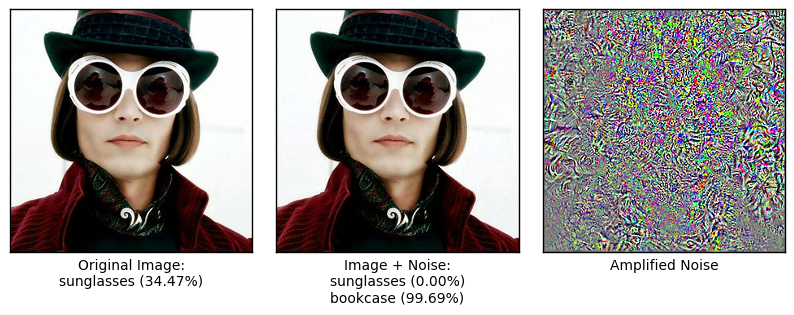

Noise min: -3.000, max: 3.000, mean: 0.011, std: 1.494


In [18]:
image_path = "images/willy_wonka_new.jpg"

adversary_example(image_path=image_path,
                  cls_target=300,
                  noise_limit=3.0,
                  required_score=0.99)

Willy Wonka (새 영화 버젼)의 이미지에서, 인셉션 모델은 원래 'sunglasses') (점수 34.47%)로 분류했지만, 인셉션 모델이 'bookcase' (점수 99.17%) 라고 확신하는 적대적 노이즈를 만들었다.

이 두 이미지는 동일해 보인다. 하지만 컴퓨터 모니터를 약간 기울이면 흰색 영역에서 약간 변화한 노이즈 패턴을 볼 수 있다.

### Willy Wonka (Old)

Iteration: 0
Source score:  97.98%, class-number:  817, class-name: bow tie
Target score:   0.00%, class-number:  300, class-name: bookcase
Gradient min: -0.002919, max:  0.002900, stepsize:   2398.23

Iteration: 1
Source score:  12.09%, class-number:  817, class-name: bow tie
Target score:   0.08%, class-number:  300, class-name: bookcase
Gradient min: -0.000896, max:  0.001319, stepsize:   5306.37

Iteration: 2
Source score:   1.32%, class-number:  817, class-name: bow tie
Target score:   0.29%, class-number:  300, class-name: bookcase
Gradient min: -0.000694, max:  0.000516, stepsize:  10083.73

Iteration: 3
Source score:   8.58%, class-number:  817, class-name: bow tie
Target score:   0.68%, class-number:  300, class-name: bookcase
Gradient min: -0.000753, max:  0.000678, stepsize:   9299.32

Iteration: 4
Source score:   1.07%, class-number:  817, class-name: bow tie
Target score:   1.27%, class-number:  300, class-name: bookcase
Gradient min: -0.000980, max:  0.000926, stepsize:  

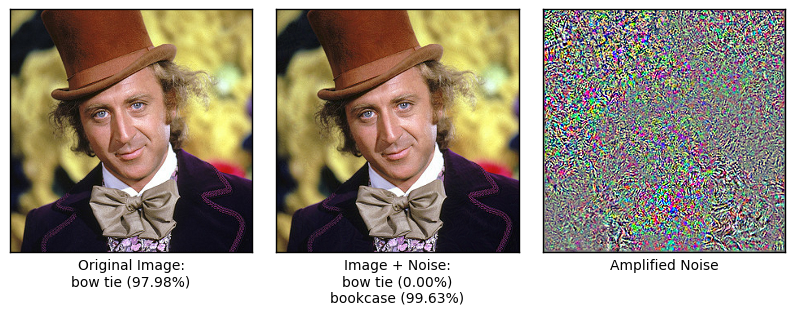

Noise min: -3.000, max: 3.000, mean: 0.000, std: 1.455


In [19]:
image_path = "images/willy_wonka_old.jpg"

adversary_example(image_path=image_path,
                  cls_target=300,
                  noise_limit=3.0,
                  required_score=0.99)

Willy Wonka (옛 영화 버젼의 이미지는 원래 'bow tie' (점수 97.98%) 로 분류되었다. 하지만 다시 적대적 노이즈를 더해주면 'bookcase' (점수 99.71%)로 분류된다.

## Close TensorFlow Session

텐서플로 사용을 마쳤고, 리소스를 풀기 위해 세션을 닫는다. 두개의 텐서플로 세션 중 하나는  model 객체 안에 있고 그래서 객체를 통해 세션을 닫는다

In [20]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()
# model.close()

## Conclusion

우리는 인셉션 모델이 이미지를 잘못 분류하게 만드는 적대적 예제라 불리는 것을 찾는 방법을 보였다. 간단한 최적화 과정을 통해, 입력 이미지에 더 할 수 있는 노이즈를 찾는다. 이 노이즈는 인셉션 모델이 이미지를 잘못 분류하게 만든다. 심지어 각 픽셀은 약간만 변해서 사람은 알아볼 수 없는 차이다. 

게다가, 노이즈는 거의 100%의 주어진 점수로 최적화 될 수 있다. 그래서 입력 이미지를 잘못 분류할 뿐만 아니라 신경망이 이 이미지를 올바르게 분류했다고 매우 확신한다.

이것은 신경망의 일반적인 문제이고, 매우 심각한 무넺다! 우리는 왜 이런 일이 일어나는지와 어떻게 고치는지를 올바르게 이해할 때까지, 중요한 문제에서 신경망을 믿을 수 없다. 상상해보라 신경망이 입력 이미지를 잘못 분류했기 때문에 만약 자율 주행 차가 정지 신호를 무시하거나 길에 지나는 사람을 무시한다면 무엇일이 일어나겠는가? 

이 문제의 연구가 지속되고 있고, 이 주제에 대한 최신 연구를 인터넷 검색을 통해 찾을 수 있다. 이 문제의 해법을 찾을 수 있을까?

## Exercises

* 자신의 이미지를 사용해 시도해보라
* `adversary_example()` 에 대한 다른 인자를 시도해보라. 다른 타겟 클래스, 노이즈 한계, 요구 점수. 그 결과는 무엇인가?
* 어떤 원하는 타겟 클래스에 대해 잘못 분류하게 하는 적대적 노이즈를 만들 수 있다고 생각하는가? 어떻게 증명할 것인가?
* `find_adversary_noise()` 에서 계단 크기를 계산하는 다른 공식을 시도해라. 최적화 수렴을 더 빠르게 할 수 있는가?
* 신경망에 입력하기 전에 노이즈 낀 입력 이미지를 흐리게 해보라. 이것이 적대적 노이즈를 없애고 다시 올바른 분류를 하게 하는가?
* 흐리게 하는 것 대신 노이즈 낀 입력 이미지의 bit-depth를 낮춰보라. 이것이 적대적 노이즈를 없애고 올바른 분류의 결과를 내는가? 예를 들어 일반적으로 255 단계 대신 Red, Green, Blue 에 대해 16 이나 32 색깔 수준만을 허용한다면
* 노이즈 제거가 MNIST 데이터셋 손글씨 숫자나 이상한 기하학적 모양에 대해서도 작동한다고 생각하는가? 이것들은 때때로 'fooling images' 라 불린다 인터넷 검색을 해보라.
* 모든 이미지에 대해 효과가 있는 적대적 노이즈를 찾을 수 있나? 그러면 각 이미지에 대해 특화된 적대적 이미지를 찾을 필요가 없나? 어떻게 할 것인가?
* NumPy를 사용하는 것 대신 텐서플로에서 직접적으로 `find_adversary_noise()` 안에 최적화를 구현할 수 있는가? 텐서플로 그래프에서 노이즈 변수를 만들 필요가 있고, 그러면 이것은 텐서플로로 최적화 될 것이다.
* 친구에게 적대적 예제가 무엇인지와 프로그램이 어떻게 찾을 수 있는지 설명하라

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.